# Creating factors from the stocks

In [1]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm
from tqdm import notebook

In [13]:
# Fetch the current list of S&P 500 constituents
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_table = pd.read_html(sp500_url)
sp500_df = sp500_table[0]
# Define the period
start_date = '2008-01-01'
end_date = '2023-12-31'

# Extract the list of tickers
sp500_tickers = sp500_df['Symbol'].tolist()
try:
    with open('s&p500.csv', 'r') as file:
        data = pd.read_csv(file)
except FileNotFoundError:
    data = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']


In [14]:
# Set 'Date' column as the index
data.set_index('Date', inplace=True)
data = data.pct_change()

In [15]:
data.fillna(0, inplace=True)

In [35]:
covariances = data.cov()
correlations = data.corr()

In [41]:
corr_row_sums = correlations.sum(axis=1)
max_corr_stock = corr_row_sums.idxmax()

'HON'

In [157]:
def factor_analysis(data: pd.DataFrame, N: int):
    """
    Perform factor analysis on the given data.

    Parameters:
    data (pd.DataFrame): The input dataframe containing stock market indices and their returns.
    N (int): The number of iterations to perform the factor analysis.

    Returns:
    factors (pd.DataFrame): The dataframe containing the identified factors.
    new_data (pd.DataFrame): The dataframe with adjusted time series after factor extraction.
    """
    # Create a copy of the input data
    new_data = data.copy()
    # Initialize an empty dataframe for factors
    factors = pd.DataFrame()
    # Initialize a list to store factor loadings
    factor_loadings = []

    for _ in notebook.tqdm(range(N)):
        # 1. Compute the correlation matrix of the new data
        corr_matrix = abs(new_data.corr())
        
        # 2. Sum the correlations for each row
        corr_sums = corr_matrix.sum(axis=1)
        
        # 3. Find the index of the row with the largest sum of correlations
        max_corr = corr_sums.idxmax()
        
        # Initialize a dictionary to store the adjusted indices
        updated_indices = {}
        # Initialize a list to store beta coefficients
        betas = []
        
        # 4. Perform a linear regression between each index and max_corr
        for col in new_data.columns:
            if col != max_corr:
                X = new_data[max_corr]
                y = new_data[col]
                X = sm.add_constant(X)  # Adds the intercept term
                model = sm.OLS(y, X).fit()
                alpha, beta = model.params
                
                # 5. Adjust the other index by subtracting beta * max_corr
                adjusted_index = y - beta * new_data[max_corr]
                updated_indices[col] = adjusted_index
                betas.append(beta)
        
        # 6. Update the new_data to include the adjusted indices
        for col in new_data.columns:
            if col != max_corr:
                new_data[col] = updated_indices[col]
        
        # Add the max_corr column to factors and the list of betas to factor_loadings
        factors[max_corr] = new_data[max_corr]
        factor_loadings.append(betas)
        
        # Drop the max_corr column from new_data for the next iteration
        new_data.drop(columns=[max_corr], inplace=True)

    return factors, new_data


In [158]:
# Example usage:
# Assuming 'df' is your DataFrame with the stock market indices and their returns
N = 10  # Number of iterations
factors_2017, new_data_2017 = factor_analysis(data['2018-01': '2018-04'], N)
factors_2018, new_data_2018 = factor_analysis(data['2018-01': '2018-05'], N)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [159]:
new_data_2018.cov().sum(axis=1).max() # Variance not explained my my factors

0.00660699351052943

In [160]:
data['2018-05': '2018-08'].cov().sum(axis=1).max() # Total variance in the desired time period

0.04760565106554844

In [163]:
factors_2017.head()

,AOS,BEN,O,BAC,AON,MPWR,LLY,PNW,DD,SLB
Date,,,,,,,,,,
2018-01-02,0.004079,-0.005160,-0.007834,0.009424,-0.020992,0.030227,0.002243,-0.000625,0.000407,0.026737
2018-01-03,0.006014,-0.000259,-0.004460,-0.009494,0.013956,0.017773,-0.003876,-0.011105,0.013996,0.013869
2018-01-04,0.004685,-0.007257,-0.022436,0.007547,0.012234,0.005212,0.000314,0.004011,0.018347,0.013590
2018-01-05,0.012864,-0.004212,-0.004296,-0.006707,0.003039,-0.003394,0.007248,-0.004277,0.007272,-0.001966
2018-01-08,0.004763,0.004165,-0.000524,-0.012605,-0.001989,0.013015,-0.009275,0.007469,-0.010772,0.013656


In [162]:
factors_2018.head()

,AOS,TROW,O,MPWR,CINF,AEE,TRMB,VZ,DD,BAC
Date,,,,,,,,,,
2018-01-02,0.004079,-0.020868,-0.005238,0.044297,-0.019326,-0.000550,0.015641,0.018655,0.001727,0.005714
2018-01-03,0.006014,0.008906,-0.005510,0.008215,-0.009376,-0.001088,0.020805,-0.021904,0.005912,-0.008419
2018-01-04,0.004685,0.004130,-0.023445,0.005162,0.009513,0.000828,0.006886,0.006794,0.012376,-0.004215
2018-01-05,0.012864,0.008023,-0.005319,-0.012988,-0.004421,0.000034,-0.009275,-0.004394,0.003381,-0.003806
2018-01-08,0.004763,0.020934,-0.002915,-0.004513,-0.013456,0.013910,-0.005293,-0.002191,-0.010069,-0.014258


In [2]:
# Trying to find the minimum risk portfolio given our set of factors

from scipy.optimize import minimize
import numpy as np

def find_max(df: pd.DataFrame, lambda_: float):
    """
    Find the set of weights that maximize V * W - lambda * W.T * COV * W, where V is the return vector,
    with the constraints that the sum of weights equals 1 and each weight is between 0 and 1.

    Parameters:
    df (pd.DataFrame): A DataFrame representing the returns.
    lambda_ (float): The risk averseness parameter.

    Returns:
    np.ndarray: The set of weights that maximize the objective function.
    """
    # Convert DataFrame to matrix V
    V = df.values.mean(axis=0)  # Assuming V is the mean return vector
    COV = df.cov().values

    # Define the objective function (negated for maximization)
    def objective_function(W, V, COV, lambda_):
        return -(np.dot(V, W) - lambda_ * np.dot(W.T, np.dot(COV, W)))  # Negative for maximization

    # Define the constraint that the sum of weights equals 1
    constraints = ({
        'type': 'eq',
        'fun': lambda W: np.sum(W) - 1
    })

    # Define the bounds for each weight
    bounds = [(0, 1) for _ in range(V.shape[0])]

    # Initial guess for weights (N-dimensional vector)
    initial_weights = np.ones(V.shape[0]) / V.shape[0]  # Start with equal weights summing to 1

    # Optimize
    result = minimize(objective_function, initial_weights, args=(V, COV, lambda_), constraints=constraints, bounds=bounds)

    # Extract optimized weights
    optimized_weights = result.x

    return optimized_weights

In [165]:
factors_2018, new_data_2018 = factor_analysis(data['2018-01': '2018-05'], 5)
input_data = data.loc['2018-01': '2018-05', factors_2018.columns]
optimized_weights = find_max(input_data, 1)
print("Optimized weights:", optimized_weights)

  0%|          | 0/5 [00:00<?, ?it/s]

Optimized weights: [2.01243476e-01 4.78437056e-01 1.31080043e-16 3.20319468e-01
 0.00000000e+00]


In [168]:
optimized_weights = find_max(input_data, 5)
print("Optimized weights:", optimized_weights)

Optimized weights: [1.59359656e-01 8.40640344e-01 0.00000000e+00 0.00000000e+00
 3.36102673e-17]


In [147]:
input_data.values.mean(axis=0)

array([ 0.0002134 ,  0.00121199, -0.00046302,  0.00079208, -0.00178256])

In [38]:
# Calculate drawdowns and count the number of drawdowns of 50% or more
drawdown_counts = 0
threshold = 0.3
for stock in ['NVDA']: #data.columns:
    stock_data = data[stock].dropna().values
    significant_drawdowns = count_significant_drawdowns(stock_data, threshold)
    drawdown_counts += significant_drawdowns

print(f'Number of drawdowns of 50% or more: {drawdown_counts}')

Number of drawdowns of 50% or more: 2


In [3]:
data = yf.download(['NVDA', '^GSPC'], start='2021-12-31', end='2024-07-03')['Adj Close']
data.columns = ['NVDA', '^GSPC']
data.index.name = 'Date'

[*********************100%%**********************]  2 of 2 completed


In [4]:
data = data.pct_change()
data.fillna(0, inplace=True)
data.head()

,NVDA,^GSPC
Date,,
2021-12-31,0.000000,0.000000
2022-01-03,0.024141,0.006374
2022-01-04,-0.027589,-0.000630
2022-01-05,-0.057562,-0.019393
2022-01-06,0.020794,-0.000964


In [5]:
X = data['^GSPC']
y = data['NVDA']
X = sm.add_constant(X)  # Adds the intercept term
model = sm.OLS(y, X).fit()
alpha, beta = model.params

data['NVDA_detrend'] = y - beta * data['^GSPC']

In [21]:
import matplotlib.pyplot as plt

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['^GSPC'], data['NVDA'])
plt.scatter(data['^GSPC'], data['NVDA_detrend'])
plt.title('Scatter plot of NVDA vs ^GSPC')
plt.xlabel('^GSPC')
plt.ylabel('NVDA')
plt.grid(True)
plt.show()

KeyError: '^GSPC'

<Figure size 1000x600 with 0 Axes>

In [20]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize

nvda_values = data['NVDA'].values

# Define the negative log-likelihood functions
def neg_log_likelihood_cauchy(params, data):
    loc, scale = params
    return -np.sum(stats.cauchy.logpdf(data, loc=loc, scale=scale))

def neg_log_likelihood_t(params, data):
    df, loc, scale = params
    return -np.sum(stats.t.logpdf(data, df=df, loc=loc, scale=scale))

def neg_log_likelihood_gaussian(params, data):
    loc, scale = params
    return -np.sum(stats.norm.logpdf(data, loc=loc, scale=scale))

# Initial parameter guesses
initial_params_cauchy = [np.median(nvda_values), np.std(nvda_values)]
initial_params_t = [10, np.median(nvda_values), np.std(nvda_values)]
initial_params_gaussian = [np.mean(nvda_values), np.std(nvda_values)]

# Fit Cauchy distribution
result_cauchy = minimize(neg_log_likelihood_cauchy, initial_params_cauchy, args=(nvda_values,), bounds=[(None, None), (0.01, None)])
loc_cauchy, scale_cauchy = result_cauchy.x
log_likelihood_cauchy = -result_cauchy.fun

# Fit t-distribution
result_t = minimize(neg_log_likelihood_t, initial_params_t, args=(nvda_values,), bounds=[(1, None), (None, None), (0.01, None)])
df_t, loc_t, scale_t = result_t.x
log_likelihood_t = -result_t.fun

# Fit Gaussian distribution
result_gaussian = minimize(neg_log_likelihood_gaussian, initial_params_gaussian, args=(nvda_values,), bounds=[(None, None), (0.01, None)])
loc_gaussian, scale_gaussian = result_gaussian.x
log_likelihood_gaussian = -result_gaussian.fun

# Compute VaR at the 95% confidence level
confidence_level = 0.95
alpha = 1 - confidence_level

# VaR
var_cauchy = stats.cauchy.ppf(alpha, loc=loc_cauchy, scale=scale_cauchy)
var_t = stats.t.ppf(alpha, df=df_t, loc=loc_t, scale=scale_t)
var_gaussian = stats.norm.ppf(alpha, loc=loc_gaussian, scale=scale_gaussian)

# CVaR calculation as the expectation of values below VaR
def cvar_cauchy(alpha, loc, scale):
    x = stats.cauchy.ppf(alpha, loc=loc, scale=scale)
    return (1/alpha) * stats.cauchy.expect(lambda t: t, lb=-np.inf, ub=x, loc=loc, scale=scale)

def cvar_t(alpha, df, loc, scale):
    x = stats.t.ppf(alpha, df=df, loc=loc, scale=scale)
    return (1/alpha) * stats.t.expect(lambda t: t, lb=-np.inf, ub=x, args=(df,), loc=loc, scale=scale)

def cvar_gaussian(alpha, loc, scale):
    x = stats.norm.ppf(alpha, loc=loc, scale=scale)
    return (1/alpha) * stats.norm.expect(lambda t: t, lb=-np.inf, ub=x, loc=loc, scale=scale)

cvar_cauchy_value = cvar_cauchy(alpha, loc_cauchy, scale_cauchy)
cvar_t_value = cvar_t(alpha, df_t, loc_t, scale_t)
cvar_gaussian_value = cvar_gaussian(alpha, loc_gaussian, scale_gaussian)

# Calculate AIC and BIC
def calculate_aic_bic(log_likelihood, num_params, num_samples):
    aic = 2 * num_params - 2 * log_likelihood
    bic = np.log(num_samples) * num_params - 2 * log_likelihood
    return aic, bic

num_samples = len(nvda_values)
aic_cauchy, bic_cauchy = calculate_aic_bic(log_likelihood_cauchy, 2, num_samples)
aic_t, bic_t = calculate_aic_bic(log_likelihood_t, 3, num_samples)
aic_gaussian, bic_gaussian = calculate_aic_bic(log_likelihood_gaussian, 2, num_samples)

# Kolmogorov-Smirnov (KS) Test
ks_cauchy = stats.kstest(nvda_values, 'cauchy', args=(loc_cauchy, scale_cauchy)).statistic
ks_t = stats.kstest(nvda_values, 't', args=(df_t, loc_t, scale_t)).statistic
ks_gaussian = stats.kstest(nvda_values, 'norm', args=(loc_gaussian, scale_gaussian)).statistic

# Print results
result_summary = {
    "Distribution": ["Cauchy", "T-Distribution", "Gaussian"],
    "Location": [loc_cauchy, loc_t, loc_gaussian],
    "Scale": [scale_cauchy, scale_t, scale_gaussian],
    "VaR": [var_cauchy, var_t, var_gaussian],
    "CVaR": [cvar_cauchy_value, cvar_t_value, cvar_gaussian_value],
    "Log-Likelihood": [log_likelihood_cauchy, log_likelihood_t, log_likelihood_gaussian],
    "AIC": [aic_cauchy, aic_t, aic_gaussian],
    "BIC": [bic_cauchy, bic_t, bic_gaussian],
    "KS Test": [ks_cauchy, ks_t, ks_gaussian]
}

result_df = pd.DataFrame(result_summary)

result_df

c:\Users\arash\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2912: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  lbc = integrate.quad(fun, lb, c, **kwds)[0]


,Distribution,Location,Scale,VaR,CVaR,Log-Likelihood,AIC,BIC,KS Test
0,Cauchy,0.001284,0.014036,-0.087336,-3.877378,8350.518509,-16697.037019,-16684.435465,0.047397
1,T-Distribution,0.001309,0.020254,-0.044800,-0.072198,8683.208526,-17360.417052,-17341.514721,0.010418
2,Gaussian,0.001519,0.030988,-0.049451,-0.062400,8276.376181,-16548.752362,-16536.150808,0.069506


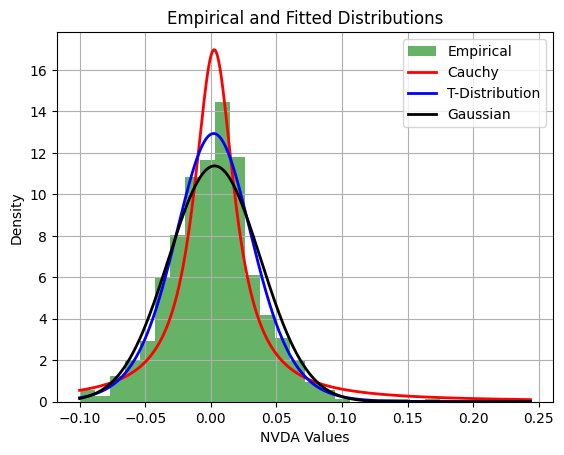

In [104]:
# Plot the empirical distribution and the fitted distributions
x = np.linspace(min(nvda_values), max(nvda_values), 1000)

# Plot empirical distribution
plt.hist(nvda_values, bins=30, density=True, alpha=0.6, color='g', label='Empirical')

# Plot Cauchy distribution
plt.plot(x, stats.cauchy.pdf(x, loc=loc_cauchy, scale=scale_cauchy), 'r-', lw=2, label='Cauchy')

# Plot T-distribution
plt.plot(x, stats.t.pdf(x, df=df_t, loc=loc_t, scale=scale_t), 'b-', lw=2, label='T-Distribution')

# Plot Gaussian distribution
plt.plot(x, stats.norm.pdf(x, loc=loc_gaussian, scale=scale_gaussian), 'k-', lw=2, label='Gaussian')

# Add legend and labels
plt.legend()
plt.xlabel('NVDA Values')
plt.ylabel('Density')
plt.title('Empirical and Fitted Distributions')
plt.grid(True)
plt.show()

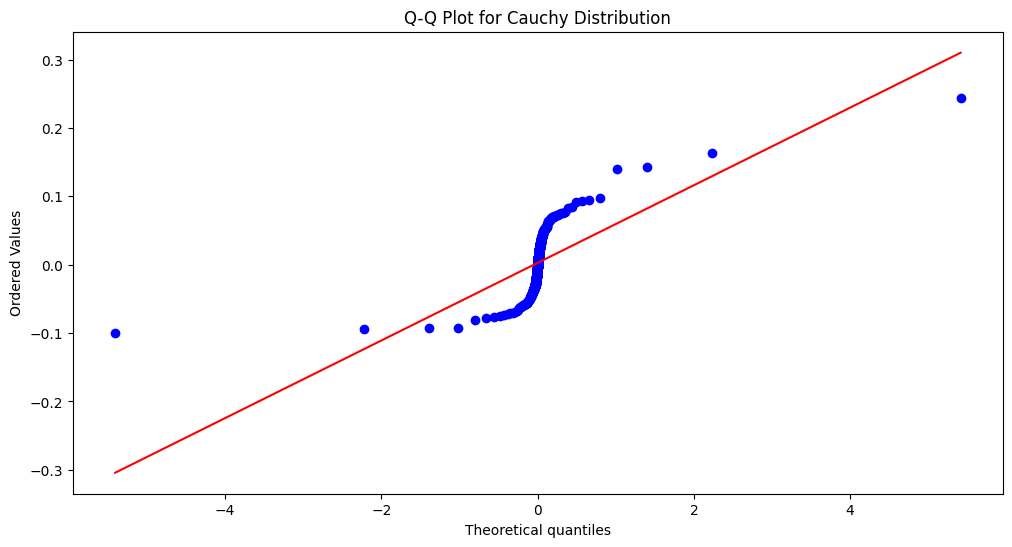

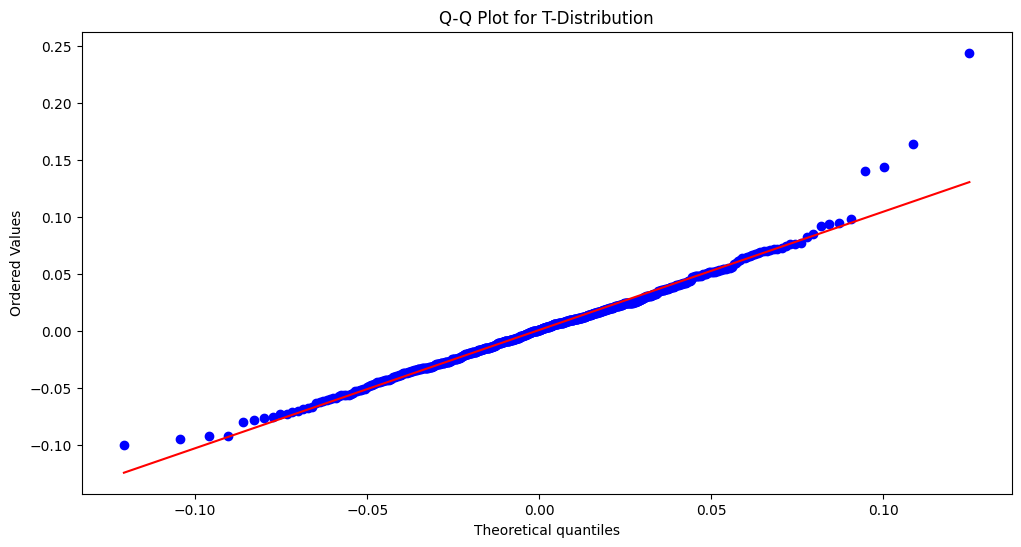

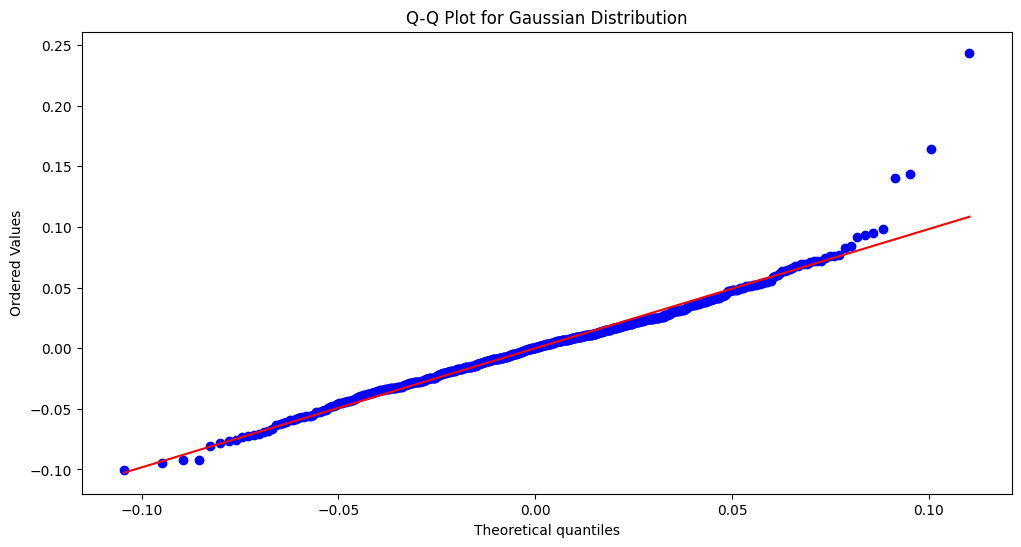

In [105]:
# Q-Q plot for Cauchy distribution
plt.figure(figsize=(12, 6))
stats.probplot(nvda_values, dist="cauchy", sparams=(loc_cauchy, scale_cauchy), plot=plt)
plt.title("Q-Q Plot for Cauchy Distribution")
plt.show()

# Q-Q plot for T-distribution
plt.figure(figsize=(12, 6))
stats.probplot(nvda_values, dist="t", sparams=(df_t, loc_t, scale_t), plot=plt)
plt.title("Q-Q Plot for T-Distribution")
plt.show()

# Q-Q plot for Gaussian distribution
plt.figure(figsize=(12, 6))
stats.probplot(nvda_values, dist="norm", sparams=(loc_gaussian, scale_gaussian), plot=plt)
plt.title("Q-Q Plot for Gaussian Distribution")
plt.show()

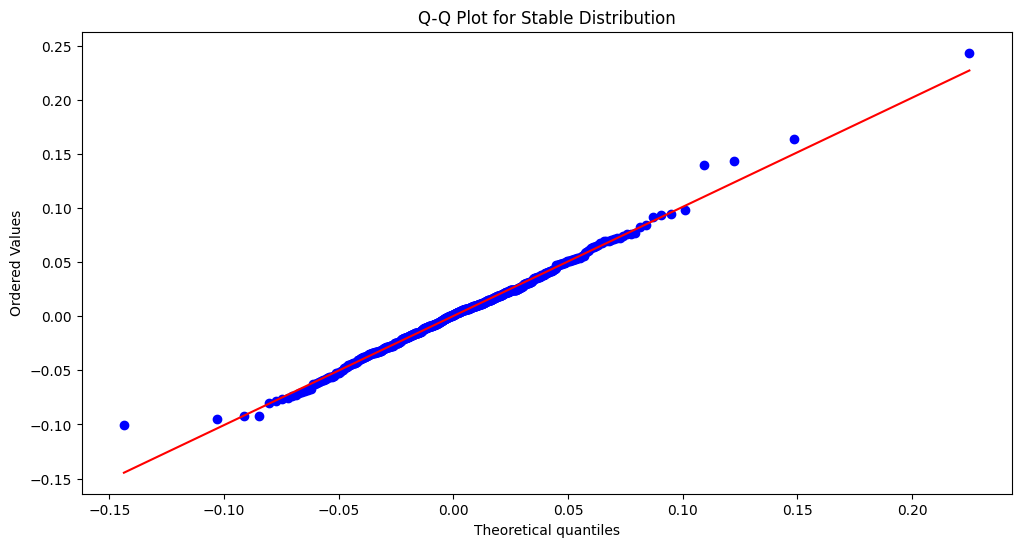

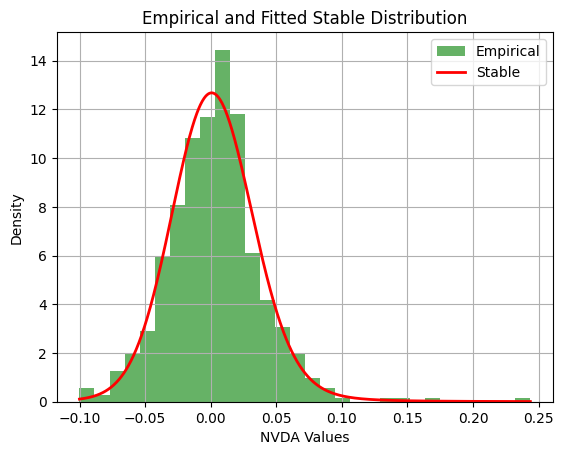

Stable Distribution Parameters: alpha=1.8831199697213168, beta=0.41677232004489323, loc=0.0026895932740471414, scale=0.022271038137836027


In [106]:
# Fit the stable distribution
params = stats.levy_stable.fit(nvda_values)

# Extract the alpha, beta, loc, and scale parameters
alpha, beta, loc, scale = params

# Generate QQ plot for Stable distribution
fig, ax = plt.subplots(figsize=(12, 6))
stats.probplot(nvda_values, dist="levy_stable", sparams=(alpha, beta, loc, scale), plot=ax)
ax.set_title("Q-Q Plot for Stable Distribution")
plt.show()

# Plot the empirical distribution and the fitted stable distribution
x = np.linspace(min(nvda_values), max(nvda_values), 1000)
plt.hist(nvda_values, bins=30, density=True, alpha=0.6, color='g', label='Empirical')
plt.plot(x, stats.levy_stable.pdf(x, alpha, beta, loc=loc, scale=scale), 'r-', lw=2, label='Stable')
plt.legend()
plt.xlabel('NVDA Values')
plt.ylabel('Density')
plt.title('Empirical and Fitted Stable Distribution')
plt.grid(True)
plt.show()

# Print the fitted stable distribution parameters
print(f"Stable Distribution Parameters: alpha={alpha}, beta={beta}, loc={loc}, scale={scale}")

In [107]:
def compute_product(distribution, params, T):
    """
    Computes the product of (1 + dist(t)) for t from 0 to T,
    where dist(t) is drawn from the specified distribution.

    Parameters:
    - distribution: A scipy.stats distribution object (e.g., stats.norm, stats.cauchy).
    - params: Parameters for the distribution (tuple).
    - T: Number of periods (integer).

    Returns:
    - product: The computed product value.
    """
    product = np.ones(T+1)
    for t in range(1, T + 1):
        dist_t = max(distribution.rvs(*params), -1)
        product[t] = product[t-1] * (1 + dist_t)
    return product

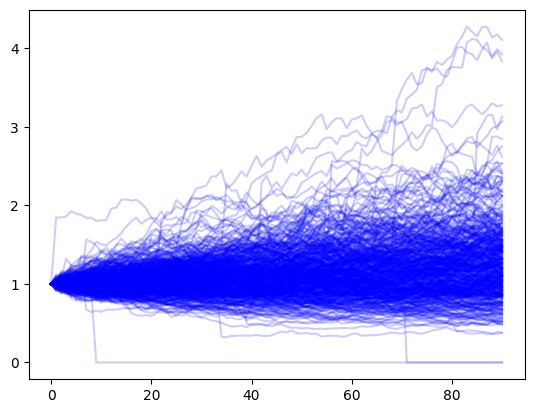

In [108]:
# Example usage
T = 90  # Number of business days
number_of_runs = 500
final_return = np.ones(number_of_runs)
for i in range(number_of_runs):
    product_levy_stable = compute_product(stats.levy_stable, params, T)
    final_return[i] = product_levy_stable[-1]
    plt.plot(product_levy_stable,'b', alpha=0.2)

In [111]:
sum(final_return<0.5)/number_of_runs

0.016

In [16]:
kendall_tau_matrix = data.corr(method='kendall')
corr = data.corr()

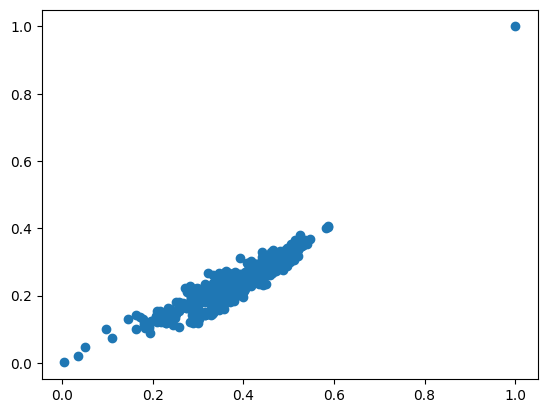

In [25]:
plt.scatter(corr['AAPL'], kendall_tau_matrix['AAPL'])

In [33]:
from tqdm import tqdm
def normalized_cross_correlation(x, y, lag):
    """ Compute normalized cross-correlation at a given lag. """
    if lag > 0:
        return np.corrcoef(x[lag:], y[:-lag])[0, 1]
    elif lag < 0:
        return np.corrcoef(x[:lag], y[-lag:])[0, 1]
    else:
        return np.corrcoef(x, y)[0, 1]

def find_max_normalized_convolution(df, max_lag):
    """ Find maximum normalized cross-correlation and its lag for each pair of columns in the DataFrame. """
    results = {}
    columns = df.columns
    for i in tqdm(range(len(columns))):
        for j in range(i + 1, len(columns)):
            x = df[columns[i]].values
            y = df[columns[j]].values
            max_corr = 0
            best_lag = 0
            for lag in range(-max_lag, max_lag + 1):
                corr = normalized_cross_correlation(x, y, lag)
                if abs(corr) > abs(max_corr):
                    max_corr = corr
                    best_lag = lag
            results[(columns[i], columns[j])] = (max_corr, best_lag)
    return results

In [34]:
max_lag = 2
results = find_max_normalized_convolution(data, max_lag)

100%|██████████| 503/503 [01:24<00:00,  5.98it/s]


In [37]:
for item in results.keys():
    if results[item][1] != 0:
        print(f'{item}: {results[item]}')

('AAL', 'MRNA'): (-0.027720625816625804, 1)
('AAPL', 'VLTO'): (0.00926483807839151, -1)
('ABBV', 'ABNB'): (0.023619081764648858, -2)
('ABBV', 'GEHC'): (0.030518932259759577, 2)
('ABNB', 'AMGN'): (-0.013437944522207826, -2)
('ABNB', 'ATO'): (-0.01808187202621316, -2)
('ABNB', 'BDX'): (0.044478367837786, 1)
('ABNB', 'BMY'): (-0.019820299122769093, -2)
('ABNB', 'CAG'): (-0.01232674014918257, -2)
('ABNB', 'CHD'): (0.029861310269694748, 1)
('ABNB', 'CLX'): (0.035413185201791465, -2)
('ABNB', 'CMS'): (0.021517067094430502, 1)
('ABNB', 'CPB'): (-0.02268102854412223, 1)
('ABNB', 'D'): (0.019949041109084676, -1)
('ABNB', 'DUK'): (0.016681126629830373, 1)
('ABNB', 'ED'): (-0.016859488061972978, 2)
('ABNB', 'HRL'): (-0.023438129988228376, 2)
('ABNB', 'HSY'): (-0.008639266170755167, 1)
('ABNB', 'JNJ'): (-0.02170600325519452, -2)
('ABNB', 'KHC'): (-0.028386566290917105, 1)
('ABNB', 'KMB'): (-0.0174834127151364, -2)
('ABNB', 'KVUE'): (-0.035941642886483986, 2)
('ABNB', 'LLY'): (0.039780277626720636,

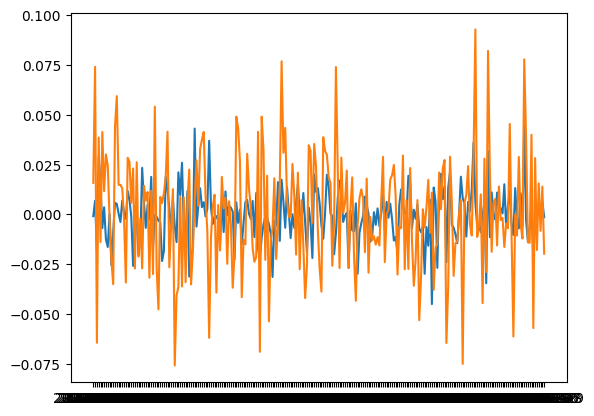

In [42]:
plt.plot(data.loc['2023':,'AEP'])
plt.plot(data.loc['2023':,'CZR'])

In [5]:
from openai import OpenAI
client = OpenAI()

TEMPLATES = [
    {'site': 'usaspending.gov', 'query': '{sym} government contracts spending awards usaspending.gov', 'focus': 'federal spending contracts'},
    {'site': 'echo.epa.gov', 'query': '{sym} EPA environmental violations compliance echo.epa.gov', 'focus': 'EPA violations'},
    {'site': 'fda.gov', 'query': '{sym} FDA recall warning letter fda.gov', 'focus': 'FDA recalls or warnings'},
    {'site': 'WARN notices', 'query': '{sym} WARN layoff notice PDF', 'focus': 'WARN Act layoff notices'},
    {'site': 'ImportGenius', 'query': '{sym} ImportGenius customs manifest shipments', 'focus': 'ImportGenius customs data'},
    {'site': 'Panjiva', 'query': '{sym} Panjiva international shipments trade', 'focus': 'Panjiva shipment records'},
    {'site': 'patents.google.com', 'query': '{sym} patents 2024 recent filings patents.google.com', 'focus': 'recent patents'},
    {'site': 'PACER/courts', 'query': '{sym} lawsuit complaint court filing PACER', 'focus': 'court filings'},
    {'site': 'reddit/twitter', 'query': '{sym} Reddit r/stocks Twitter investor sentiment 2024', 'focus': 'social media mentions'},
    {'site': 'options activity', 'query': 'unusual options activity {sym} calls puts volume', 'focus': 'unusual options activity'}
]

def alt_intel(name: str, short_ans=True):
    for tmpl in TEMPLATES:
        query = tmpl['query'].format(sym=name)
        site = tmpl['site']
        focus = tmpl['focus']
        
        instructions = f"You are a stock analyst helping with finding publically available info about a stock. STRICT RULE: If search results are NOT from {site} domain/source, respond ONLY with: NO_RESULTS. Do not make up bullshit fluf around the response. Just NO_RESULTS. Do NOT mention covidstimuluswatch, wikipedia, or ANY other site. Only report if you find data SPECIFICALLY from {site} about {name} on {focus}. Any other source or data = NO_RESULTS."
        
        resp = client.responses.create(
            model="gpt-4o",
            tools=[{"type": "web_search_preview",
                    "search_context_size": "low"}],
            input=query,
            **({"max_output_tokens": 200} if short_ans else {}),
            instructions=instructions
        )
        
        print(f"{site}: {query} → {resp.output_text}\n")

# example
alt_intel("MICROSOFT CORP")

usaspending.gov: MICROSOFT CORP government contracts spending awards usaspending.gov → NO_RESULTS 

echo.epa.gov: MICROSOFT CORP EPA environmental violations compliance echo.epa.gov → NO_RESULTS 

fda.gov: MICROSOFT CORP FDA recall warning letter fda.gov → NO_RESULTS 

WARN notices: MICROSOFT CORP WARN layoff notice PDF → Microsoft Corporation has filed multiple WARN (Worker Adjustment and Retraining Notification) Act layoff notices in various states, including California, Oregon, and Washington. These notices are publicly accessible through state labor department websites.

For instance, the Oregon Rapid Response Activity Tracking System provides access to specific WARN notices filed by Microsoft:

- **November 6, 2017**: [WARN 2210 Microsoft 11.6.17.pdf](https://ccwd.hecc.oregon.gov/Layoff/WARN/UploadIndex/2210)

- **December 5, 2017**: [WARN 2210 Revised Microsoft 12.5.17.pdf](https://ccwd.hecc.oregon.gov/Layoff/WARN/UploadIndex/2210) 

ImportGenius: MICROSOFT CORP ImportGenius cust